# AUXILIAR 10: ARMA model en procesos estocásticos y periodograma en serie periodica!!

Por Javiera Toro Grey para el curso AS4501: Astroinformática, Otoño 2025.


# Modelo ARMA

Se nos pide estudiar la variabilidad de la curva de luz del AGN variable PKS 2155-304.

Pero qué características tiene este AGN?


PKS 2155-304 es un objeto BL Lac, una galaxia que alberga un tipo de blazar. Es un fuerte emisor de radio a frecuencias de alta energía. PKS 2155-304 tiene un corrimiento al rojo z = 0.116. Es uno de los BL Lacs más brillantes y estudiados, uno de los primeros identificados a través de observaciones de rayos X.

In [53]:
# DEPENDENCIAS
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import shapiro, normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.arima.model import ARIMA

## Obtención de la curva de luz

Revisamos la cantidad de curvas de luz disponibles por la misión TESS para el objeto!

In [8]:
target = 'PKS 2155-304'
lk.search_targetpixelfile(target, mission="TESS")

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 28,2020,SPOC,120,229013191,0.0
1,TESS Sector 28,2020,TESS-SPOC,600,229013191,0.0


Usaremos la mas larga

In [9]:
pixelfile = lk.search_targetpixelfile(target, mission="TESS")[1].download()

Podemos visualizar la observacion de este objeto:

In [10]:
pixelfile.animate()

No se ve que sea muy variable, al parecer no cambia mucho. Pero revisemos la curva de luz de este objeto!

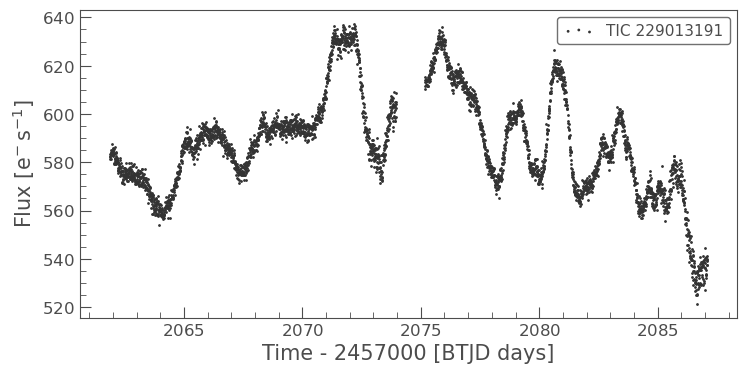

In [11]:
pixelfile.to_lightcurve(method='pld').remove_outliers().scatter()
plt.show()

Esta curva de luz nos muestra que es estocástica, es decir, que es aleatorio. No hay una tendencia clara en esta curva y además, que los procesos físicos que la generan tambien son probabilísticos (Porque es un BL Lac)

In [15]:
search = lk.search_lightcurve(target, mission='TESS')[1]
lc = search.download_all().stitch().remove_nans()


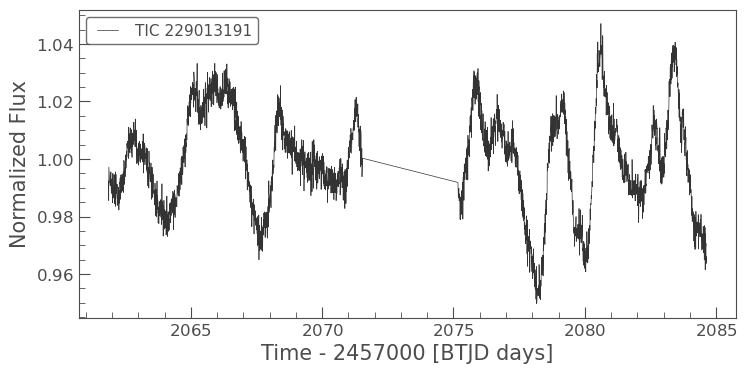

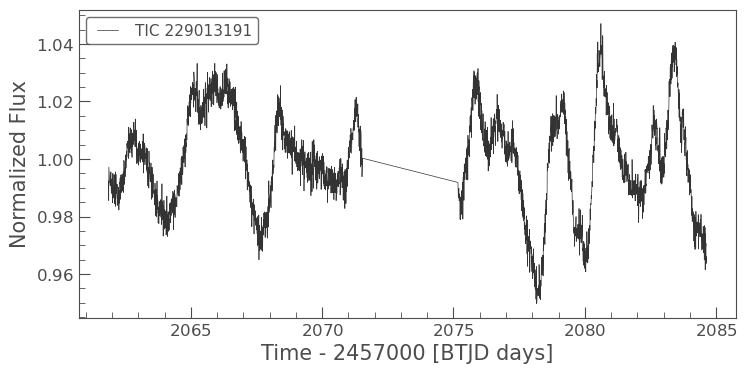

In [17]:
lc.plot()
plt.show()

In [42]:
lc_clean = lc.flatten()
time, flux_masked = lc_clean.time.value, lc_clean.flux.value
flux = flux_masked.unmasked

Para poder modelar estas curvas de luz, necesitamos usar modelos ARMA (AutoRegressive Moving Average).


¿Por qué?


Los modelos ARMA son herramientas fundamentales para analizar predecir series temporales. Pues AR modela la dependencia temporal y MA las perturbaciones aleatorias en el proceso físico.

El modelo ARMA es mas general que uno puramente aleatorio (ruido blanco) o puramente determinista (sinusoide), lo que permite ajustar tanto suavidad (AR) como fluctuaciones rápidas (MA), esto lo haremos con los valores p y q del modelo.

Las componentes p y q son difíciles de modelar ya que nos cuentan sobre los procesos fisicos en el AGN, reflejan relaciones fijas en el tiempo.

Para esto debemos considerar:

1. Componente AR (AutoRegressive) (p):
   - Modela el valor actual como una combinacion lineal de los valores anteriores
   - Captura los efectos de la "memoria" en la curva de luz

2. Componente MA (Moving Average) (q):
   - Modela el valor actual como una combinacion lineal de los errores pasados
   - Capturalos efectos en la variabilidad


Pero tiene sus restricciones, las metricas tienen que ser estacionarios, o sea que las estadisticas no cambien en el tiempo (media, varianza)

## Revisamos metricas estacionarias

Los test que usaremos para revisar que las metricas sean estacionarias serán:


1. ADF (Augmented Dickey-Fuller) Test (Revisa que la serie sea estacionaria para AR, random walks):
    - Hipótesis nula: L aserie tine un unit root (no es estacionario)
    - Queremos que el p-value < 0.05 para rechazar hipotesis nula

2. KPSS Test (Revisa que la serie sea estacionaria en la tendencia (promedio constante)):
    - Hipótesis nula: La serie tiene metricas estacionarias
    - Queremos p-value > 0.05 para no rechazar hipotesis nula


In [43]:
def check_stationarity(series):
    """
    Perform comprehensive stationarity checks
    """

    # ADF Test
    adf_result = adfuller(series)
    print(f"ADF Test: Statistic={adf_result[0]:.3f}, p-value={adf_result[1]:.3f}")

    # KPSS Test
    kpss_result = kpss(series, regression='c')
    print(f"KPSS Test: Statistic={kpss_result[0]:.3f}, p-value={kpss_result[1]:.3f}")

    # Interpretation
    if adf_result[1] > 0.05:
        print("ADF suggests non-stationary (fail to reject null hypothesis)")
    else:
        print("ADF suggests stationary (reject null hypothesis)")

    if kpss_result[1] < 0.05:
        print("KPSS suggests non-stationary (reject null hypothesis)")
    else:
        print("KPSS suggests stationary (fail to reject null hypothesis)")

print("\nStationarity Analysis:")
check_stationarity(flux)


Stationarity Analysis:
ADF Test: Statistic=-12.773, p-value=0.000
KPSS Test: Statistic=0.006, p-value=0.100
ADF suggests stationary (reject null hypothesis)
KPSS suggests stationary (fail to reject null hypothesis)


Ahora revisamos la correlaciones:

ACF (Función de Autocorrelación):
	•	Muestra la correlación entre la serie y sus retardos (lags, cuanto se parece a los valores anteriores)
	•	Una decadencia lenta sugiere una componente AR
	•	Un corte abrupto después del retardo q sugiere un modelo MA(q)

PACF (Función de Autocorrelación Parcial):
	•	Muestra la correlación directa entre la serie y un retardo, eliminando los efectos intermedios
	•	Un corte abrupto después del retardo p sugiere un modelo AR(p)


Correlation Diagnostics:


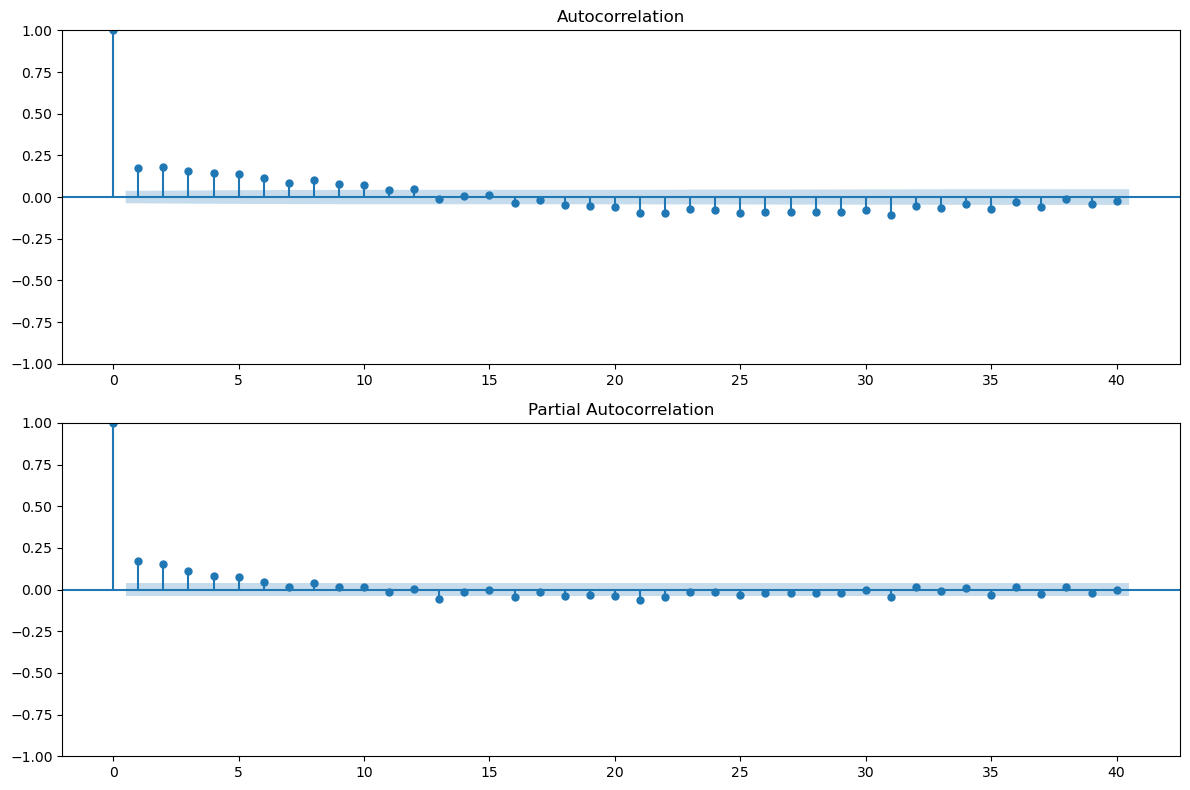

In [47]:
def plot_correlation_diagnostics(series, lags=40):
    """
    Plot ACF and PACF for model order identification

    """
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series, lags=lags, ax=ax1)
    plot_pacf(series, lags=lags, ax=ax2, method='ywm')
    plt.tight_layout()
    plt.show()

print("\nCorrelation Diagnostics:")
plot_correlation_diagnostics(flux)

Con esto sabemos que podemos aplicar el modelo ARMA a esta curva de luz

## Modelo

Ahora entrenamos el modelo con las siguientes metricas:

1. Metricas In-Samples (en sample de entrenamiento):
    - MSE: Mean Squared Error (sensible a outliers)
    - RMSE: Root MSE
    - MAE: Mean Absolute Error (more robust)

2. Metricas Out-of-sample (en sample de testeo):
    - Los mismos que antes

3. Criterios de información:
    - AIC: Akaike Information Criterion (balancea el fit y la complejidad)
    - BIC: Bayesian IC (Penaliza fuertemente por la complejidad)
    - Queremos valores pequeños

4. Residuos:
    - Deberia ser white noise (no autocorrelación)
    - Deberia ser normalmente distribuidos
    - Deberia tener una varianza constante


Evaluating ARMA(2,2) Model:

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1920
Model:                 ARIMA(2, 0, 2)   Log Likelihood                8100.992
Date:                Tue, 10 Jun 2025   AIC                         -16189.985
Time:                        22:47:06   BIC                         -16156.624
Sample:                             0   HQIC                        -16177.710
                               - 1920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000      0.000   2819.353      0.000       0.999       1.001
ar.L1          0.4194      0.907      0.462      0.644      -1.359       2.198
ar.L2  

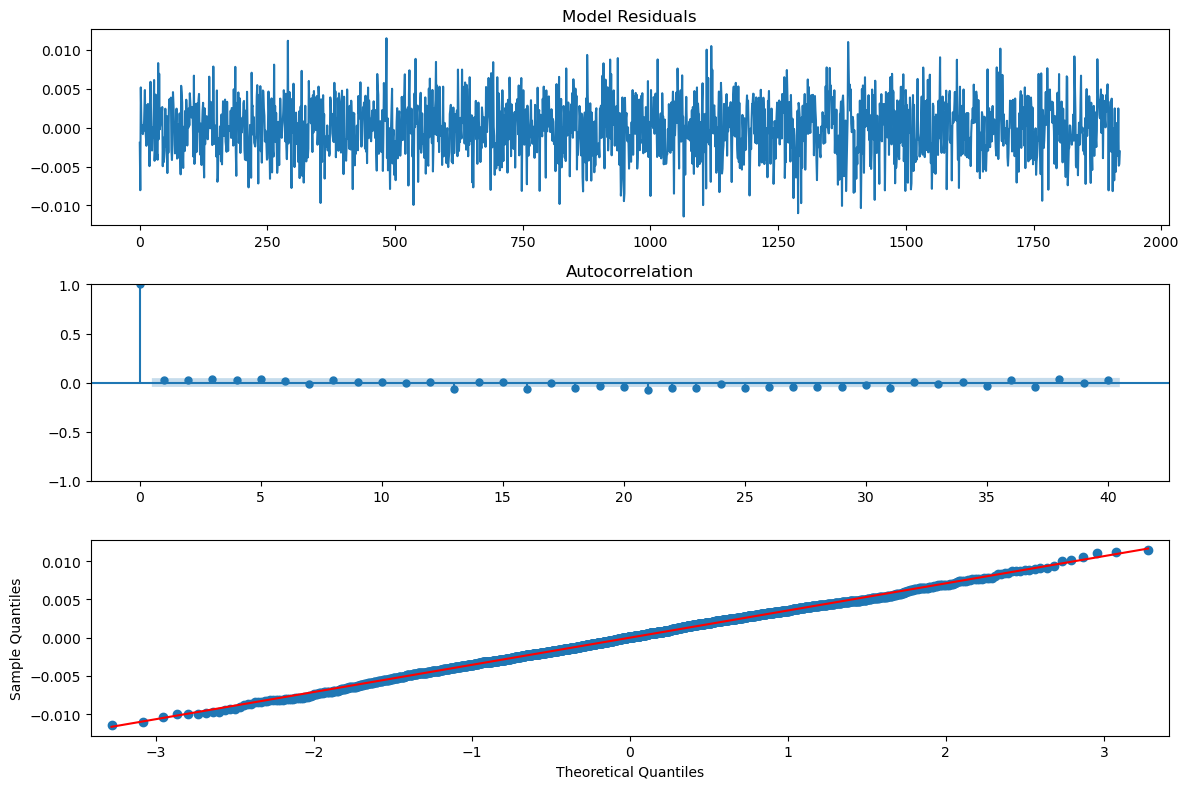

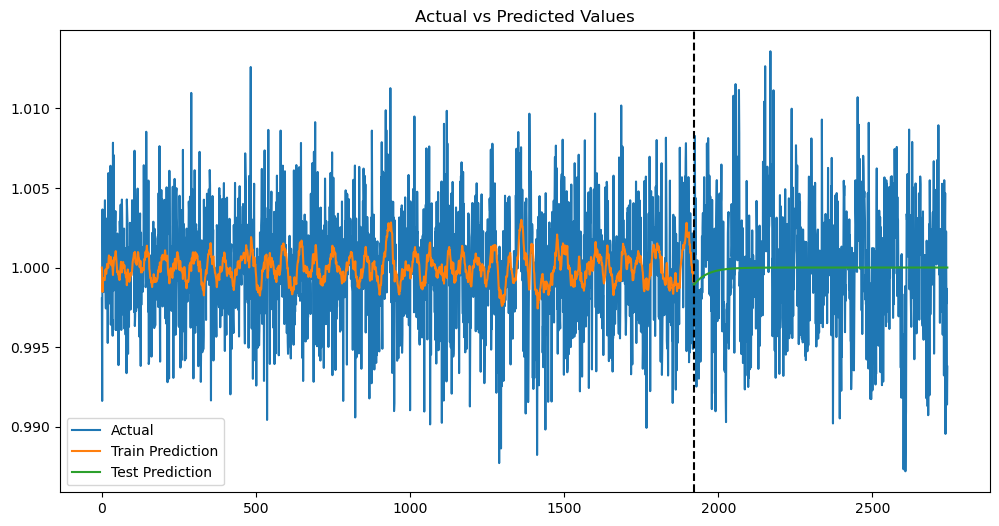

In [55]:
def evaluate_arma_model(series, p, q, train_ratio=0.7, plot=False):
    """
    Fit ARMA model and provide comprehensive evaluation

    """
    # Split data respecting temporal order
    split_idx = int(len(series) * train_ratio)
    train, test = series[:split_idx], series[split_idx:]

    # Fit model
    model = ARIMA(train, order=(p, 0, q))
    model_fit = model.fit()

    # Generate predictions
    train_pred = model_fit.predict()
    test_pred = model_fit.forecast(steps=len(test))

    # Calculate evaluation metrics
    def calculate_metrics(true, pred, prefix):
        mse = mean_squared_error(true, pred)
        rmse = sqrt(mse)
        mae = mean_absolute_error(true, pred)
        return {
            f'{prefix}_mse': mse,
            f'{prefix}_rmse': rmse,
            f'{prefix}_mae': mae
        }

    metrics = {}
    metrics.update(calculate_metrics(train, train_pred, 'train'))
    metrics.update(calculate_metrics(test, test_pred, 'test'))

    # Residual analysis - critical for model validity
    residuals = model_fit.resid

    # Normality tests (residuals should be ~N(0,σ²))
    shapiro_stat, shapiro_p = shapiro(residuals)
    normal_stat, normal_p = normaltest(residuals)

    # Autocorrelation tests (residuals should be uncorrelated)
    lb_results = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)

    # ARCH effects test (check for volatility clustering)
    arch_test = het_arch(residuals)

    if plot:
        # Model summary shows key parameters and diagnostics
        print("\nModel Summary:")
        print(model_fit.summary())

        print("\nModel Performance Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

        print(f"Shapiro-Wilk: stat={shapiro_stat:.3f}, p={shapiro_p:.3f}")
        print(f"Normal test: stat={normal_stat:.3f}, p={normal_p:.3f}")

        print("\nLjung-Box Test for Residual Autocorrelation:")
        print(lb_results)

        print(f"\nARCH Test (for heteroskedasticity): p-value={arch_test[1]:.3f}")

        # Plot diagnostics
        plt.figure(figsize=(12, 8))

        # Residuals plot - should look like white noise
        plt.subplot(3, 1, 1)
        plt.plot(residuals)
        plt.title('Model Residuals')

        # ACF of residuals - no significant lags
        plt.subplot(3, 1, 2)
        plot_acf(residuals, lags=40, ax=plt.gca())

        # QQ plot - should follow straight line for normality
        plt.subplot(3, 1, 3)
        sm.qqplot(residuals, line='s', ax=plt.gca())
        plt.tight_layout()
        plt.show()

        # Plot predictions vs actual
        plt.figure(figsize=(12, 6))
        plt.plot(series, label='Actual')
        plt.plot(np.arange(len(train_pred)), train_pred, label='Train Prediction')
        plt.plot(np.arange(len(train), len(series)), test_pred, label='Test Prediction')
        plt.axvline(x=len(train), color='k', linestyle='--')
        plt.legend()
        plt.title('Actual vs Predicted Values')
        plt.show()

    return model_fit, metrics

# Try different model orders and compare
print("\nEvaluating ARMA(2,2) Model:")
arma_model, arma_metrics = evaluate_arma_model(flux, 2, 2, plot=True)

Ahora que revisamos un ejemplo, comparemos varios modelos.

Los valores de p y q normalmente están entre [0; 5], pero en la vida real raramente se pasa de 3.

In [145]:
def compare_models(series, model_orders):
    """
    Compare multiple ARMA models and return metrics

    """
    results = {}
    for p, q in model_orders:
        print(f"\nEvaluating ARMA({p},{q}) Model:")
        model, metrics = evaluate_arma_model(series, p, q)
        results[(p, q)] = {
            'aic': model.aic,
            'bic': model.bic,
            'metrics': metrics
        }

    # Display comparison table
    print("\nModel Comparison:")
    print(f"{'Model':<10}{'AIC':<10}{'BIC':<10}{'Train RMSE':<15}{'Test RMSE':<15}")
    for (p, q), res in results.items():
        print(f"ARMA({p},{q}):{res['aic']:<10.1f}{res['bic']:<10.1f}"
              f"{res['metrics']['train_rmse']:<15.4f}"
              f"{res['metrics']['test_rmse']:<15.4f}")

    return results

model_orders = [(1,1), (2,1), (3,1),
                (2,1), (2,2), (2,3),
                (3,1), (3,2), (3,3)]
model_comparison = compare_models(flux, model_orders)


Evaluating ARMA(1,1) Model:

Evaluating ARMA(2,1) Model:

Evaluating ARMA(3,1) Model:

Evaluating ARMA(2,1) Model:

Evaluating ARMA(2,2) Model:

Evaluating ARMA(2,3) Model:

Evaluating ARMA(3,1) Model:

Evaluating ARMA(3,2) Model:

Evaluating ARMA(3,3) Model:

Model Comparison:
Model     AIC       BIC       Train RMSE     Test RMSE      
ARMA(1,1):-10888.9  -10866.7  0.0142         0.0039         
ARMA(2,1):-16232.2  -16204.4  0.0035         0.0039         
ARMA(3,1):-16216.0  -16182.6  0.0035         0.0039         
ARMA(2,2):-16190.0  -16156.6  0.0036         0.0039         
ARMA(2,3):-16233.8  -16194.8  0.0035         0.0039         
ARMA(3,2):-16199.4  -16160.5  0.0035         0.0039         
ARMA(3,3):-16222.8  -16178.4  0.0035         0.0039         


In [60]:
best_model_key = min(model_comparison.items(), key=lambda x: (x[1]['metrics']['test_rmse'], x[1]['aic']))[0]
print(f"Selected Best Model: ARMA {best_model_key} based on test RMSE and AIC")

Selected Best Model: ARMA (2, 1) based on test RMSE and AIC


Final Evaluation with Best Model:

Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1920
Model:                 ARIMA(2, 0, 1)   Log Likelihood                8121.084
Date:                Tue, 10 Jun 2025   AIC                         -16232.168
Time:                        23:08:01   BIC                         -16204.368
Sample:                             0   HQIC                        -16221.939
                               - 1920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000      0.000   5516.565      0.000       1.000       1.000
ar.L1          0.8856      0.046     19.415      0.000       0.796       0.975
ar

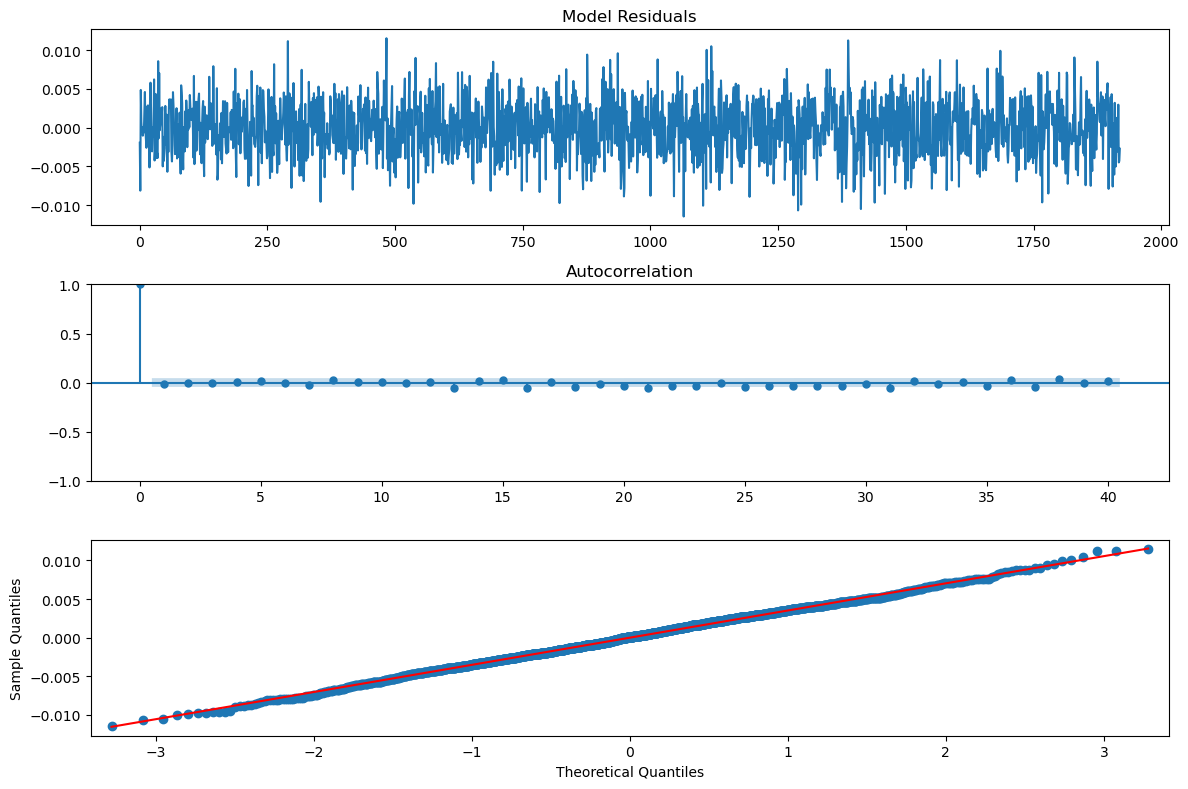

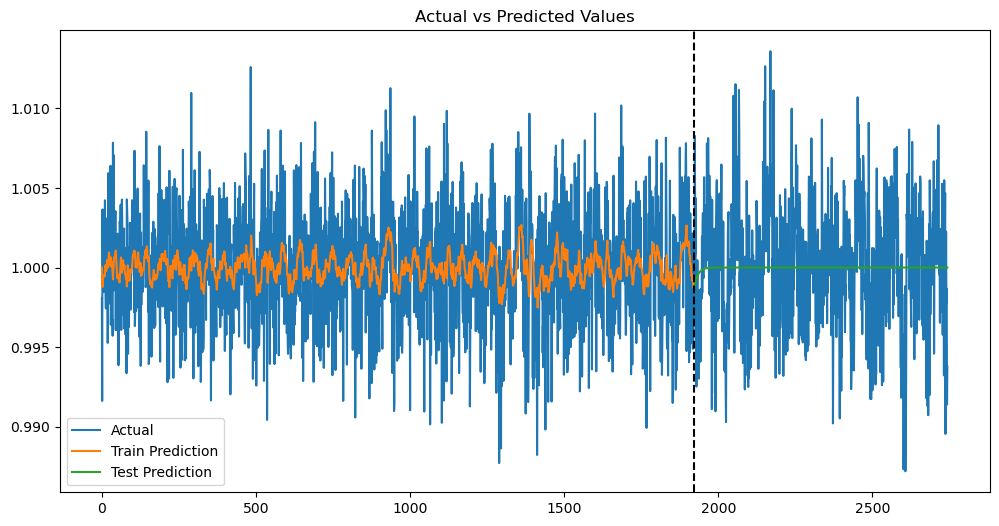

In [63]:
print("Final Evaluation with Best Model:")
final_model, final_metrics = evaluate_arma_model(flux, *best_model_key, plot=True)

# Periodograma

Vamos a caracterizar datos de TOI-163, una estrella con 1.66 masas solares y una temperatura de 6388 K, por lo que se trata de una estrella de tipo espectral F.

Hay un exoplaneta confirmado orbitando esta estrella, TOI-163b, con una masa de 1.489 masas de Júpiter.

Ahora vamos a trabajar con la curva de luz de TOI-163b.

In [140]:
# Dependencias
import corner
import emcee
import lightkurve as lk
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Primero obtenemos las curvas de luz para el exoplaneta

In [141]:
TPF = lk.search_lightcurve("TOI163b", mission="TESS")
TPF

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 09,2019,SPOC,120,179317684,0.0
1,TESS Sector 13,2019,SPOC,120,179317684,0.0
2,TESS Sector 10,2019,SPOC,120,179317684,0.0
3,TESS Sector 11,2019,SPOC,120,179317684,0.0
4,TESS Sector 12,2019,SPOC,120,179317684,0.0
5,TESS Sector 27,2020,SPOC,20,179317684,0.0
6,TESS Sector 28,2020,SPOC,20,179317684,0.0
7,TESS Sector 33,2020,SPOC,20,179317684,0.0
8,TESS Sector 30,2020,SPOC,20,179317684,0.0


Utilizaremos los primeros 5 porque tiene el mismo tiempo de exposición

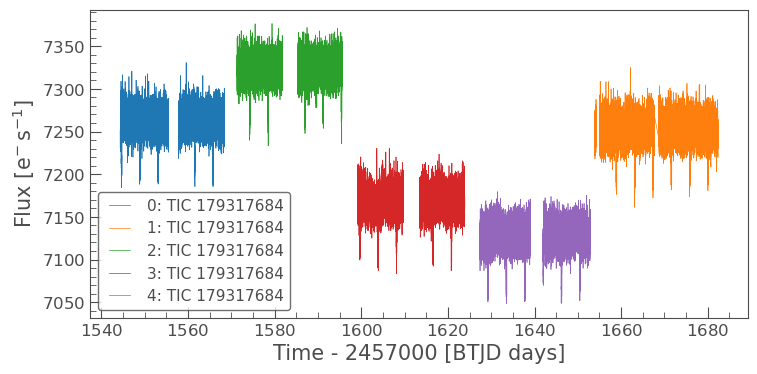

In [142]:
lc_collection = TPF[0:5].download_all()
lc_collection.plot();

Ahora el unir y normalizar las curvas:


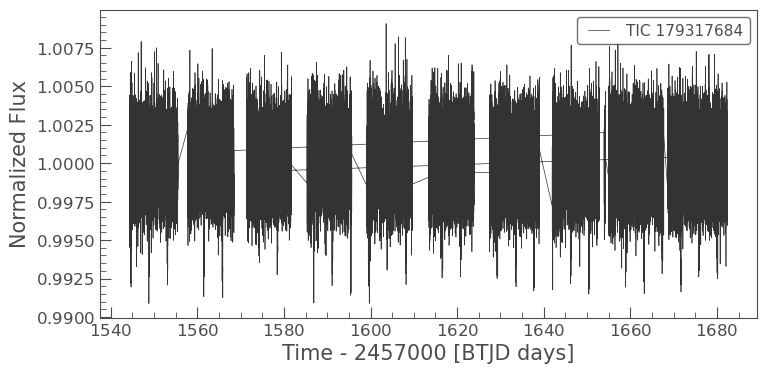

In [130]:
lc_TPF = lc_collection.stitch().flatten(window_length=1000).remove_outliers()
lc_TPF.plot();


Para explorar el tránsito del planeta, se va a utilizar el método de análisis de periodograma Box Least Squares (BLS).
El método BLS es una clase de astropy que funciona modelando un tránsito como un rectángulo invertido (forma de “top hat” hacia abajo) con cuatro parámetros: período, duración, profundidad y tiempo de referencia.

En esta implementación, el tiempo de referencia se elige como el momento medio del primer tránsito dentro del intervalo de observación.

Para esto necesitamos usar el periodograma de la estrella

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

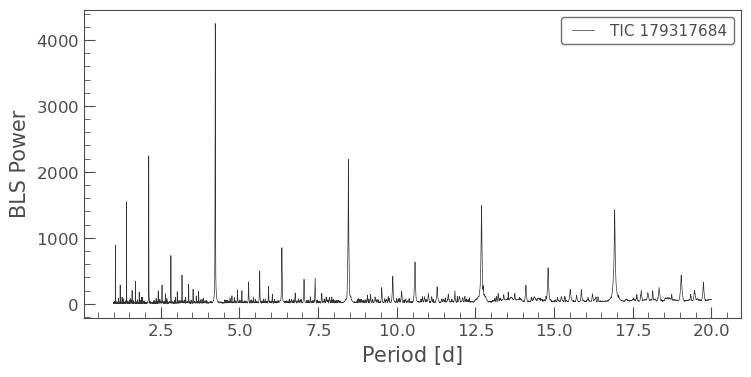

In [131]:
period1 = np.linspace(1, 20, 10000)
bls1 = lc_TPF.to_periodogram("bls", period=period1)
bls1.plot()

La potencia maxima se encuentra cercana a 4, entonces para centrar este maximo, usaremos el periodograma entre 0 y 8 dias

<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

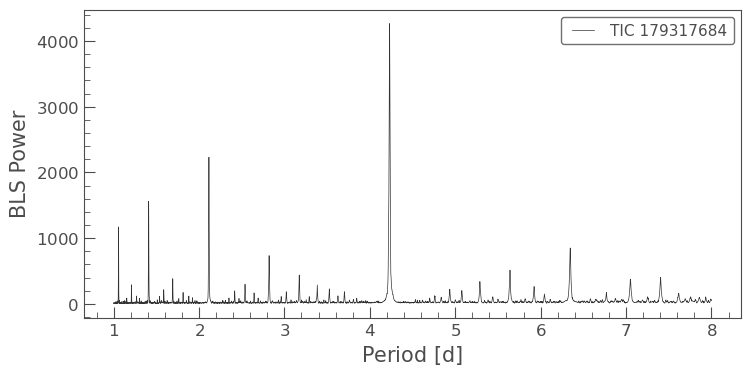

In [132]:
period = np.linspace(1, 8, 10000)
bls = lc_TPF.to_periodogram("bls", period=period)
bls.plot()

In [133]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
planet_b_deep = bls.depth_at_max_power

print(f'The estimated planet period is {np.round(planet_b_period, 4)}')

The estimated planet period is 4.2308 d


Los parámetros obtenidos son simplemente un modelo inicial para guiar la estimación futura del tránsito del planeta.
Luego, para confirmar que el período y el tiempo de tránsito realmente corresponden a un tránsito, la curva de luz se pliega (fold) en fase utilizando los parámetros obtenidos.

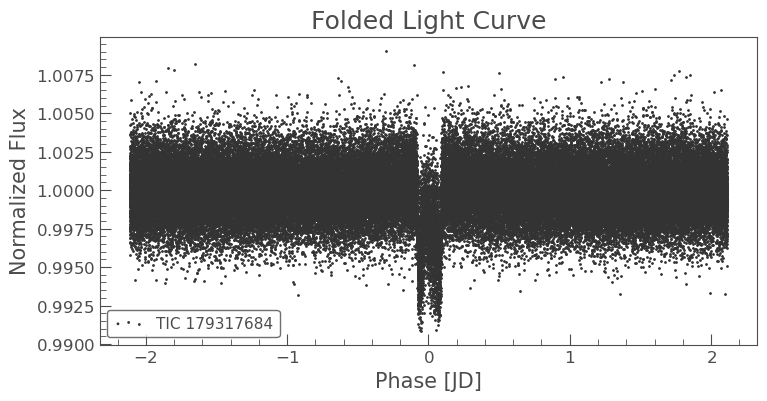

In [134]:
lc_folded = lc_TPF.fold(period=planet_b_period, epoch_time=planet_b_t0)
lc_folded.scatter()
plt.title('Folded Light Curve', fontsize=18)
plt.show();

Ahora, el tránsito del planeta está centrado en la fase 0 de la curva de luz plegada en fase.
El gráfico muestra una señal de tránsito clara utilizando el período y el tiempo de tránsito identificados en el punto de máxima potencia del BLS.

Ahora podemos modelar el transito del planeta, para esto usaremos MCMC, crearemos una funcion que describe el flujo de la estrella a cierto tiempo y luego la cadena que usar

In [135]:
def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - Rp: radius of the planet
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)

    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration
    if t < t_ingress or t > t_egress:
        return F
    else:
        return F - delta_F

x = lc_folded['time'].value
y_obs = lc_folded['flux'].value
error = np.sqrt(lc_folded['flux'].value)

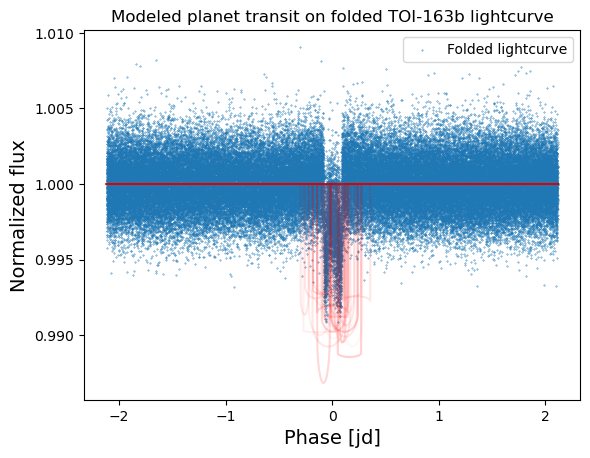

In [136]:
def model(params, x):
    Rp, Rs, c, t_ingress, t_duration = params
    mod = [flux_at_time(t, 1, Rp, Rs, c, t_ingress, t_duration) for t in time]
    return mod


def log_likelihood(params, x, y_obs):
    # Calculate the model values for each peak
    models = model(params, x)

    # Compute the residuals
    residuals = (y_obs - models)/error
    # Calculate the log likelihood
    return -0.5 * np.sum(residuals ** 2)

# The initial params are
guess_params = [1.47, 16.1, 0.15, -0.07, 0.15]

def log_prior(params):
    Rp, Rs, c, t_ingress, t_duration = params
    if 1.4 < Rp < 1.6 and 16 < Rs < 16.2 and 0 < c < 1:
        if -0.8 < t_ingress < -0.6 and 0.1 < t_duration < 0.3 :
            return 0
    return -np.inf


def log_probability(params, x, y_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y_obs)

# Initialize the MCMC sampler

ndim = 5  # Number of parameters (mean, sigma, amplitude for each peak)
nwalkers = 32  # Number of walkers
initial_params = np.random.normal(loc=guess_params,
                                  scale=[0.1, 0.1, 0.1, 0.1, 0.1],
                                  size=(nwalkers, ndim))  # Initial parameter guesses
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y_obs))

# Run the MCMC sampler
nsteps = 1000  # Number of MCMC steps
sampler.run_mcmc(initial_params, nsteps)

# Extract samples from the posterior distribution
samples = sampler.chain[:, :, :].reshape((-1, ndim))

time_axis = lc_folded['time']
# Plot the original data and the best-fitting model
plt.scatter(x, y_obs, label='Folded lightcurve', s =0.1)
for params in samples[np.random.randint(len(samples), size=100)]:
    Rp, Rs, c, t_ingress, t_duration = params
    mod = [flux_at_time(t, 1, Rp, Rs, c, t_ingress, t_duration) for t in x]
    plt.plot(x, np.array(mod), 'r', alpha=0.03)
plt.ylabel(f'Normalized flux', size=14)
plt.xlabel(f'Phase [{time_axis.format}]', size=14)
plt.title('Modeled planet transit on folded TOI-163b lightcurve')
plt.legend()
plt.show()

Revisando los parametros

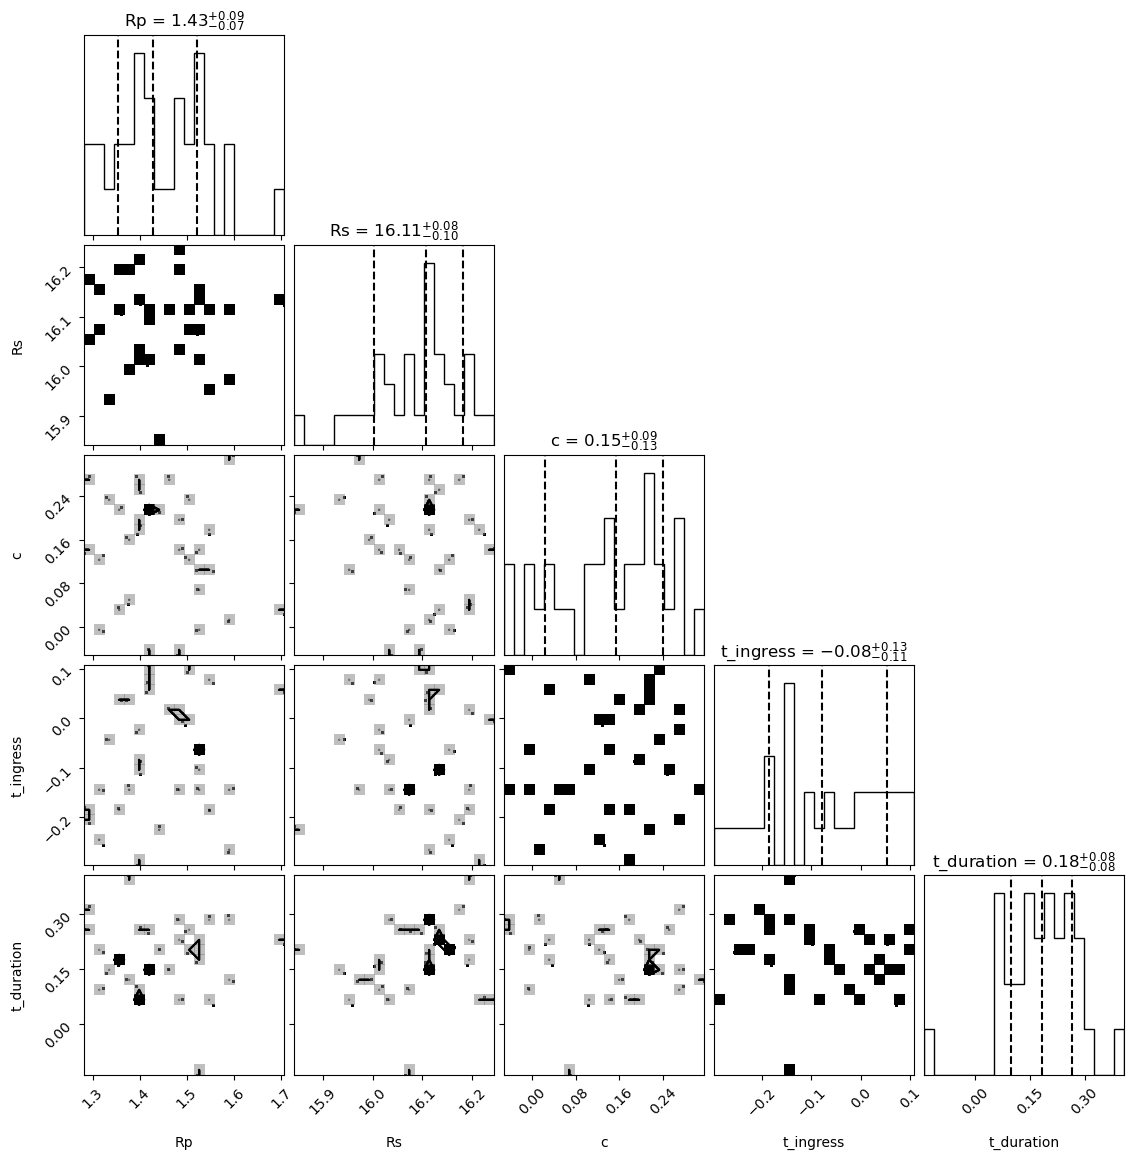

In [137]:
fig = corner.corner(samples,
                    labels=['Rp', 'Rs', 'c', 't_ingress', 't_duration'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12});

# Show the plot
plt.show();

Que se puede inferir de esto? Como podemos mejorar el modelo?


SI seguimos con esta configuracion obtendremos:

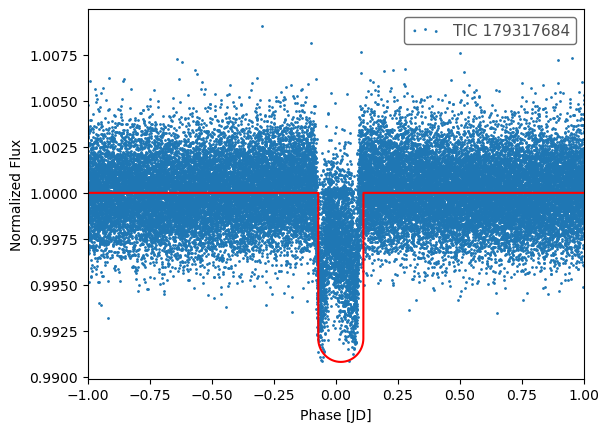

In [138]:
fig, ax = plt.subplots()

# Plot folded lc
lc_folded.scatter(ax=ax)

time = lc_folded['time'].value

params = samples[np.random.randint(len(samples), size=100)]
mean_params = np.mean(params, axis=0)

# Plot model fit

Rp, Rs, c, t_ingress, t_duration = mean_params
mod = [flux_at_time(t, 1, Rp, Rs, c, t_ingress, t_duration) for t in time]
plt.plot(time, np.array(mod), 'r')

plt.xlim(-1,1)
plt.show();

In [139]:
std_params = np.std(samples, axis=0)
rp_std, rs_std, c_std, t_ing_std, t_dur_std = std_params

Ahora, comparando los parámetros obtenidos con los reportados por $\textit{Kossakowski et al.}$ (2019), el radio estimado del planeta  $$R_{P} = 1.478^{+0.022}_{-0.029} \, R_{J}$$

Mientras que el radio calculado con MCMC es:
$$
R_{P} = 1.488^{+0.09}_{-0.09} \, R_{J}
$$

Por otro lado, el período del tránsito planetario, según el artículo, es:
$$
P = 4.231 \, \text{días}
$$

y el período estimado es:
$$
P = 4.2308 \, \text{días}
$$

Con esto, a pesar de los problemas en el cálculo con MCMC, los parámetros encontrados son similares a los reportados en artículos científicos reales. 😊